# Report - Relationship between the Charging Point Infrastructure and Electromobility in Germany
**Niklas Markert** <br>
**28th June 2023**

## Preparation

### Install Dependencies

In [1]:
%pip install geopandas
%pip install matplotlib
%pip install numpy
%pip install pandas
%pip install scipy
%pip install 'SQLAlchemy==1.4.46'

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


### Import Modules

In [2]:
import os
import subprocess
import urllib.request
import zipfile
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
from sqlalchemy import create_engine

### Load Data

In [3]:
# If database doesn't exist, run datapipeline to create it
if not os.path.exists("../data/data.sqlite"):
    subprocess.run(["python", "../data/datapipeline.py"])

# Load data from database
con = create_engine('sqlite:///../data/data.sqlite')
df1 = pd.read_sql_table('over_time', con, index_col='Year')
df2 = pd.read_sql_table('by_states', con, index_col='State')

### Prepare Data


In [4]:
# Add additional values to dataframe, needed for analysis
df2['CP per km^2'] = df2['Amount CP'] / df2['Area (km^2)']
df2['SCP per km^2'] = df2['Amount SCP'] / df2['Area (km^2)']
df2['FCP per km^2'] = df2['Amount FCP'] / df2['Area (km^2)']
df2['Percentage Electric'] = (df2['NR Plug-in-Hybrid'] + df2['NR Electric']) / df2['NR Overall']
df2['Percentage Full-Electric'] = df2['NR Electric'] / df2['NR Overall']
df2['Percentage Plug-in-Hybrid'] = df2['NR Plug-in-Hybrid'] / df2['NR Overall']

# Seperate the data for complete Germany from df2
ger = df2.loc['Germany']
df2.drop(index='Germany', inplace=True)

In [5]:
# Download the shape file of germany, if not already existing
if not os.path.exists('./DEU_adm/'):
    urllib.request.urlretrieve('https://biogeo.ucdavis.edu/data/diva/adm/DEU_adm.zip', 'DEU_adm.zip')
    with zipfile.ZipFile('DEU_adm.zip', 'r') as zip_ref:
        zip_ref.extractall('DEU_adm')
    os.remove('DEU_adm.zip')
    
# Create a geopandas dataframe needed for visualizatiion and add the columns we want to investigate
df_ger = gpd.read_file('./DEU_adm/DEU_adm1.shp') 
df_ger = df_ger.set_index('NAME_1')
df_ger['Percentage Electric'] = df2['Percentage Electric']
df_ger['CP per km^2']  = df2['CP per km^2'] 

## Introduction

### Motivation
Nowadays, the environment and especially the question of how to save it is a big issue in our society. An important factor in this context are alternative energy sources.
Especially in the field of mobility, these alternative energy sources play a major role. One possibility are electric-powered cars, either full-electric or hybrid. However, these vehicles require charging points to recharge their battery.
But not everyone has such charging stations at home, or if you drive longer distances, you always have to plan where to charge the battery of your car, which is a disadvantage of electric cars and probably affects people's willingness to drive such cars. <br>
For this reason, it would be interessting to see, if a higher amount of charging points available correlates with a higher rate in electromobility.

### Goal
The goal of this project is to analyze the relationship between the number of electric charging stations and electromobility in Germany. <br>
For this we take a look at the amount of charging points overall, combining standard charging points (SCP) and fast charging points (FCP). 
For the effect on electromobility, we will inspect the new registrations of full-electric cars and plug-in-hybrids, because they are the ones depending on charging stations.
<br><br>
In the end, this analysis should shed light on whether building more charging stations would lead to a higher share of electric cars.

### Datasources
Here a short listing of the used datasources. For a more detailed insight you can check out the [datasources.ipynb](https://github.com/nmarkert/amse/blob/main/project/datasources.ipynb) notebook.

* **Datasource1:** Charging Infrastructure in Germany
    * Link: https://www.bundesnetzagentur.de/DE/Sachgebiete/ElektrizitaetundGas/Unternehmen_Institutionen/E-Mobilitaet/Ladesaeulenkarte/start.html
    * Sheet: "4.1 Ladepunkte je BL"
    * Provides the number of charging points for every German state in a in a three-month cycle since 2017
<br><br>
* **Datasource2:** New Registrations of Motor Vehicles with Alternative Drive Systems
    * Link: https://mobilithek.info/offers/573357313572614144 _(for 2023)_
    * Sheet: "FZ 28.2" (2.1) + "FZ 28.9" (2.2)
    * Provides the new registrations of motor vehicles with alternative drive systems for each month since January 2016 _(2.1)_ and the new registrations of motor vehicles with alternative drive systems for each german state summed up over the course of a year _(2.2)_
<br><br>
* **Datasource3:** German States with Capitals by Area, Population and Population Density
    * Link: https://www.destatis.de/DE/Themen/Laender-Regionen/Regionales/Gemeindeverzeichnis/Administrativ/02-bundeslaender.html
    * Sheet: "Bundesländer_mit_Hauptstädten"
    * Provides the area and population for each german state and their capital city


### Data Transformation
The entire data transformation process takes place in the [data/datapipeline.py](https://github.com/nmarkert/amse/blob/main/data/datapipeline.py) file.
There the above mentioned datasources get loaded from the internet, cleaned, combined and stored in an sqlite-database. 
<br> <br>
The resulting database consist of two tables "over_time" and "by_states":
* **over_time:** Contains for each year from 2017 to 2022, the amount of charging points at the start of the year and the increase of charging points over the year, both values also split up into standard and fast charging points (from Datasource1) and the amount of new registrations in general, for full-electric cars and for plug-in-hybrids over the year (from Datasource2.1)

* **by_states:** Contains for each German state ("Bundesland") and also for whole Germany, the amount of charging points at the start of the year 2022 (from Datasource 1), the amount of new registratins in general, for full-electric cars and for plug-in-hybrids over the year 2022 (from Datasource2.2) and the area of each state (from Datasource3)

## Analysis

### Development over the years

First let's have a look at the development over the time.

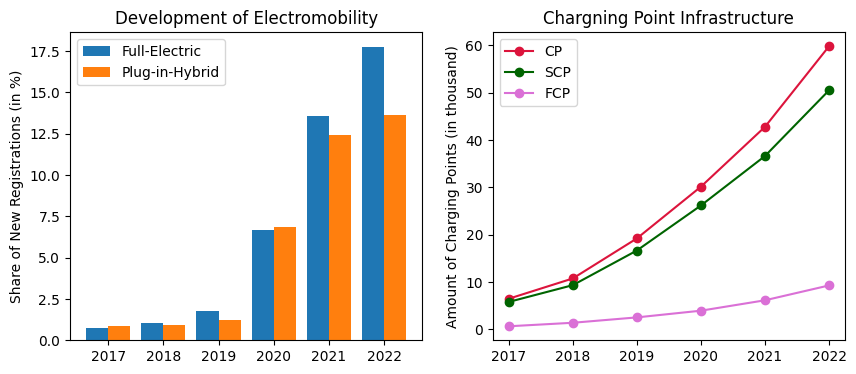

In [6]:
df1.sort_index(ascending=True, inplace=True)
X = df1.index
X_axis = np.arange(len(X))

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.bar(X_axis-0.2, (df1['NR Electric']/df1['NR Overall'])*100, 0.4, label='Full-Electric')
plt.bar(X_axis+0.2, (df1['NR Plug-in-Hybrid']/df1['NR Overall'])*100, 0.4, label='Plug-in-Hybrid')
plt.legend()
plt.title('Development of Electromobility')
plt.ylabel('Share of New Registrations (in %)')
plt.xticks(X_axis, X)

plt.subplot(1, 2, 2)
plt.plot(X_axis, df1['Amount CP']/1000, 'o-', label='CP', color="Crimson")
plt.plot(X_axis, df1['Amount SCP']/1000, 'o-', label='SCP', color="Darkgreen")
plt.plot(X_axis, df1['Amount FCP']/1000, 'o-', label='FCP', color="Orchid")
plt.legend()
plt.title('Chargning Point Infrastructure')
plt.xticks(X_axis, X)
plt.ylabel('Amount of Charging Points (in thousand)')

plt.show()

As you can see in the graphic on the left the percentage share of new regestrations for both full-electric cars and plug-in-hybrids are increasing, especially in recent years. <br>
The same applies for the amount of charging points in germany. They are steadily increasing and especially in recent years with a much higher slope than in the early years. <br>
<br>
However, to assume a dependency here would be too vague. There are a lot of factors which also effect these increases, especially the change in society and the car industry over the time.
In society, saving the environment, e.g. by using sustainable energy, is a big topic and also is increasing over the years. 
This topic goes hand in hand with the state of the car industry. Also the amount of available electric cars is steadily increasing, because more and more car manifacturer offer a wider range of cars with alternative drive systems.
<br><br>
So its hard to argue that the amount of charging points influence the electromobility in Germany, just because both values are rapidly increasing over time. <br>
For this reason, we now will take a specific point in time and have a look at the charging infrastructure and electromobility at the different states of Germany.

### Comparison between the different German States

So let's have a look at the electromobility and the charging point infrastructure in the different German states.
<br><br>
In this chapter, we will use abbrevations for the different states in the plots.
So if you are unclear which state a specific abbrevations refers to, you can have a look here.

In [7]:
df2['Abbreviation']

State
Baden-Württemberg         BW
Bayern                    BY
Berlin                    BE
Brandenburg               BB
Bremen                    HB
Hamburg                   HH
Hessen                    HE
Mecklenburg-Vorpommern    MV
Niedersachsen             NI
Nordrhein-Westfalen       NW
Rheinland-Pfalz           RP
Saarland                  SL
Sachsen                   SN
Sachsen-Anhalt            ST
Schleswig-Holstein        SH
Thüringen                 TH
Name: Abbreviation, dtype: object

First let's have a look at the new registations of full-electric cars and plug-in-hybrids per state.

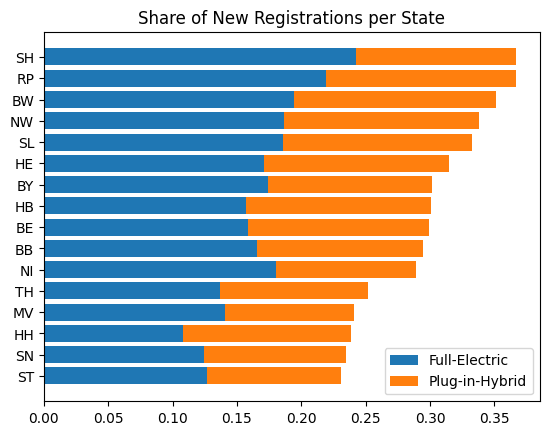

In [8]:
df2.sort_values('Percentage Electric', inplace=True)
plt.barh(df2['Abbreviation'], df2['Percentage Full-Electric'], label='Full-Electric')
plt.barh(df2['Abbreviation'], df2['Percentage Plug-in-Hybrid'], left=df2['Percentage Full-Electric'], label='Plug-in-Hybrid')
plt.legend()
plt.title('Share of New Registrations per State')
plt.show()

As you can see, that the share of new registations of electric cars differs slightly througout the states. <br>
The states with the highest rate of electric car new registrations are Schleswig-Holstein and Rheinland-Pfalz, followed by Baden-Würtenberg.
<br><br>
After looking at the new registations of electric cars, we will inspect the charging point infrastructure at each state.

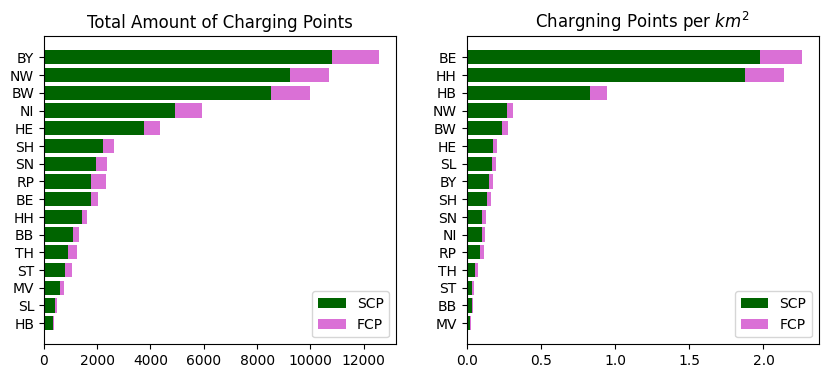

In [9]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
df2.sort_values('Amount CP', inplace=True)
plt.barh(df2['Abbreviation'], df2['Amount SCP'], label='SCP', color='Darkgreen')
plt.barh(df2['Abbreviation'], df2['Amount FCP'], left=df2['Amount SCP'], label='FCP', color='Orchid')
plt.title('Total Amount of Charging Points')
plt.legend()

plt.subplot(1, 2, 2)
df2.sort_values('CP per km^2', inplace=True)
plt.barh(df2['Abbreviation'], df2['SCP per km^2'], label='SCP', color='Darkgreen')
plt.barh(df2['Abbreviation'], df2['FCP per km^2'], left=df2['SCP per km^2'], label='FCP', color='Orchid')
plt.title('Chargning Points per $km^2$')
plt.legend()

plt.show()

The plot on the left shows the total amount of charging points in each state, split up into standard charging points (SCP) and fast charging points (FCP). Here you can see that the states with the biggest areas also have the highest number of charging points, which totaly makes sense.
For this reason we set the amount of charging point in relation to the area of the state, which results in the other plot.
<br><br>
The plot on the right shows the amount of charging points per $km^2$ for each state.
Here you can see that 3 states stand out extremely from the other, which are Berlin, Hamburg and Bremen. All three are so-called "Stadtstaaten", which means that they have a relatively small area compared to the other states and consist of only one city. So you can see them more as citys than as real states and for this reason, we will drop them from the dataset for further analysis.

In [10]:
df2.drop(index=['Berlin', 'Hamburg', 'Bremen'], inplace=True)
df_ger.drop(index=['Berlin', 'Hamburg', 'Bremen'], inplace=True)

Now lets have a look at the percentage of new registrations of electric cars (full-electric + plug-in-hybrid) and the amount of charging points per $km^2$ on a map of germany.

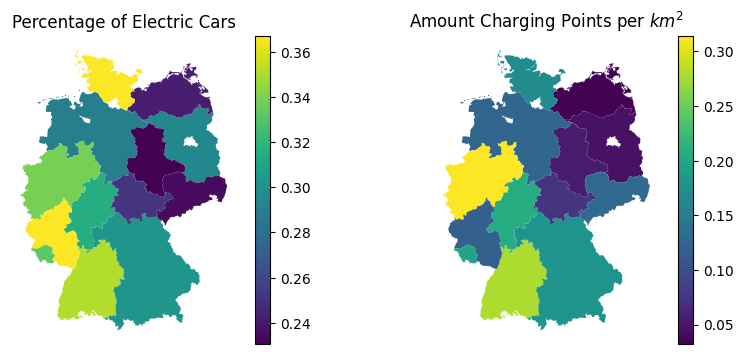

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

df_ger.plot(column='Percentage Electric', kind='geo', legend=True, ax=ax1)
ax1.axis('off')
ax1.set_title('Percentage of Electric Cars')

df_ger.plot(column='CP per km^2', kind='geo', legend=True, ax=ax2)
ax2.axis('off')
ax2.set_title('Amount Charging Points per $km^2$')

plt.show()

From this visualization we see that there could be some correlation between these two values, but to better visualize this we will use a scatter plot.

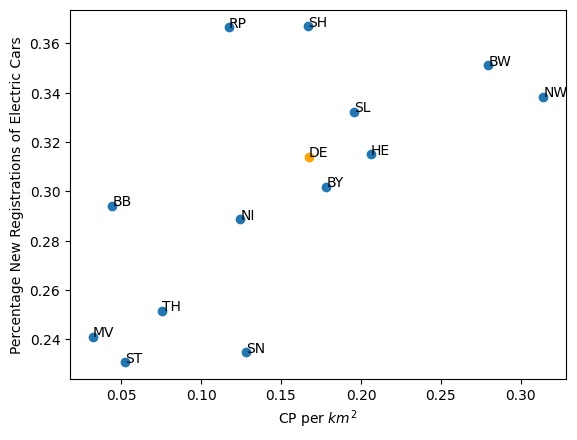

In [12]:
x_col = 'CP per km^2'
y_col = 'Percentage Electric'
x = df2[x_col]
y = df2[y_col]
plt.scatter(x, y)
plt.xlabel('CP per $km^2$')
plt.ylabel('Percentage New Registrations of Electric Cars')

ger_x = ger[x_col]
ger_y = ger[y_col]
plt.scatter(ger_x, ger_y, c='orange')
plt.text(ger_x, ger_y, 'DE',)

for state in df2.index:
    ds = df2.loc[state]
    plt.text(ds[x_col], ds[y_col], ds['Abbreviation'])

plt.show()

In this plot you can better see, that in fact states that have a low number of charging points per $km^2$, like Mecklenburg-Vorpommern or Sachsen-Anhalt, also have a lower percentage on new registrations of electric cars. And states which have a higher density on charging points, like Baden-Württemberg or Nordrhein-Westfalen, tend to have a higher percentage of electric car new registrations.
<br><br>
To also get quantitative results, we will calculate the Correlation Coeffiecnet between different variables to see if and how strong they correlate.

In [13]:
cols1 = ['Percentage Electric', 'Percentage Full-Electric', 'Percentage Plug-in-Hybrid']
cols2 = ['CP per km^2', 'SCP per km^2', 'FCP per km^2']

correlations = []
for c1 in cols1:
    for c2 in cols2:
        corr, pvalue = pearsonr(df2[c1], df2[c2])
        correlations.append({
            'x': c1,
            'y': c2,
            'Correlation Coefficient': corr,
            'p-Value': pvalue
        })

df_corr = pd.DataFrame(correlations, columns=correlations[0].keys())
df_corr.set_index(['x', 'y'], inplace=True)
df_corr.sort_values('Correlation Coefficient', ascending=False)

Correlation Coefficient   p-Value
x                         y                                              
Percentage Plug-in-Hybrid FCP per km^2                 0.784702  0.001489
                          CP per km^2                  0.779542  0.001678
                          SCP per km^2                 0.771761  0.001998
Percentage Electric       FCP per km^2                 0.689617  0.009106
                          CP per km^2                  0.653076  0.015511
                          SCP per km^2                 0.642030  0.017988
Percentage Full-Electric  FCP per km^2                 0.535684  0.059188
                          CP per km^2                  0.487002  0.091441
                          SCP per km^2                 0.475752  0.100329

As you can see the percentage of new registrations of plug-in-hybrids has the highest correlation with all of the different types of charging points. But also the general percentace of electric car new registrations correlates good with the density of charging points. <br>
Also to be mentioned, both values correlate the best with the density of fast charging points.

## Conclusion
The analysis shows that the share of electromobility and the charging station infrastructure in Germany is growing steadily over time. This mainly is caused by changes in society and car industry.
So to find a relationship between the rate of new registrations of electric cars and the amount of charging points, we primarily examined the distribution among the German states. 
Here we noticed a good correlation between the rate of electromobilty and the charging point infrastructure. This correlation was especially strong between the percentage of new registrations of plug-in-hybrids and the number of fast charging point per $km^2$. <br>
From this findings you could conclude that a higher amount of charging points available, causes a higher willingness of people driving electric powered cars, especially plug-in-hybrids.
<br><br>
But we also have to mention that we only used 13 values for calculating this correlation and doesn't consider other influential factors which could cause this to be a spurious correlation ("Scheinkorrelation"). <br>
In future works you should consider using more datapoint, for example by using data for several countries throughout europe or spliting up the data of Germany into more smaller areas. Also, like mentioned, you should consider other factors which could influence these values, like the general state of the infrastructure, the average salary of a resident, the amount of money by the state spends on saving the environment, etc.
<br><br>
Nevertheless, this project provides interessting findings on the relationship between the number of charging points and electromobility in Germany. <br>
It's important to understand how different factors influence our mobility choices, so that we can steer our future in a greener and more sustainable direction.